<a href="https://www.kaggle.com/code/vanpatangan/orders-forecasting-challenge?scriptVersionId=217094380" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

# load data

In [2]:
train_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test_df = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

# data summary  

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), 
         df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", 
                                              "unique", "sum_null", "duplicates"])

    return df_check

print("Training Data Summary")
display(check(train_df))
print("Test Data Summary")
display(check(test_df))

Training Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,warehouse,object,7340,7,0,0
1,date,object,7340,1193,0,0
2,orders,float64,7340,4426,0,0
3,holiday_name,object,218,24,7122,0
4,holiday,int64,7340,2,0,0
5,shutdown,int64,7340,2,0,0
6,mini_shutdown,int64,7340,2,0,0
7,shops_closed,int64,7340,2,0,0
8,winter_school_holidays,int64,7340,2,0,0
9,school_holidays,int64,7340,2,0,0


Test Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,warehouse,object,397,7,0,0
1,date,object,397,61,0,0
2,holiday_name,object,17,5,380,0
3,holiday,int64,397,2,0,0
4,shops_closed,int64,397,2,0,0
5,winter_school_holidays,int64,397,2,0,0
6,school_holidays,int64,397,2,0,0
7,id,object,397,397,0,0



# count plot and distribution

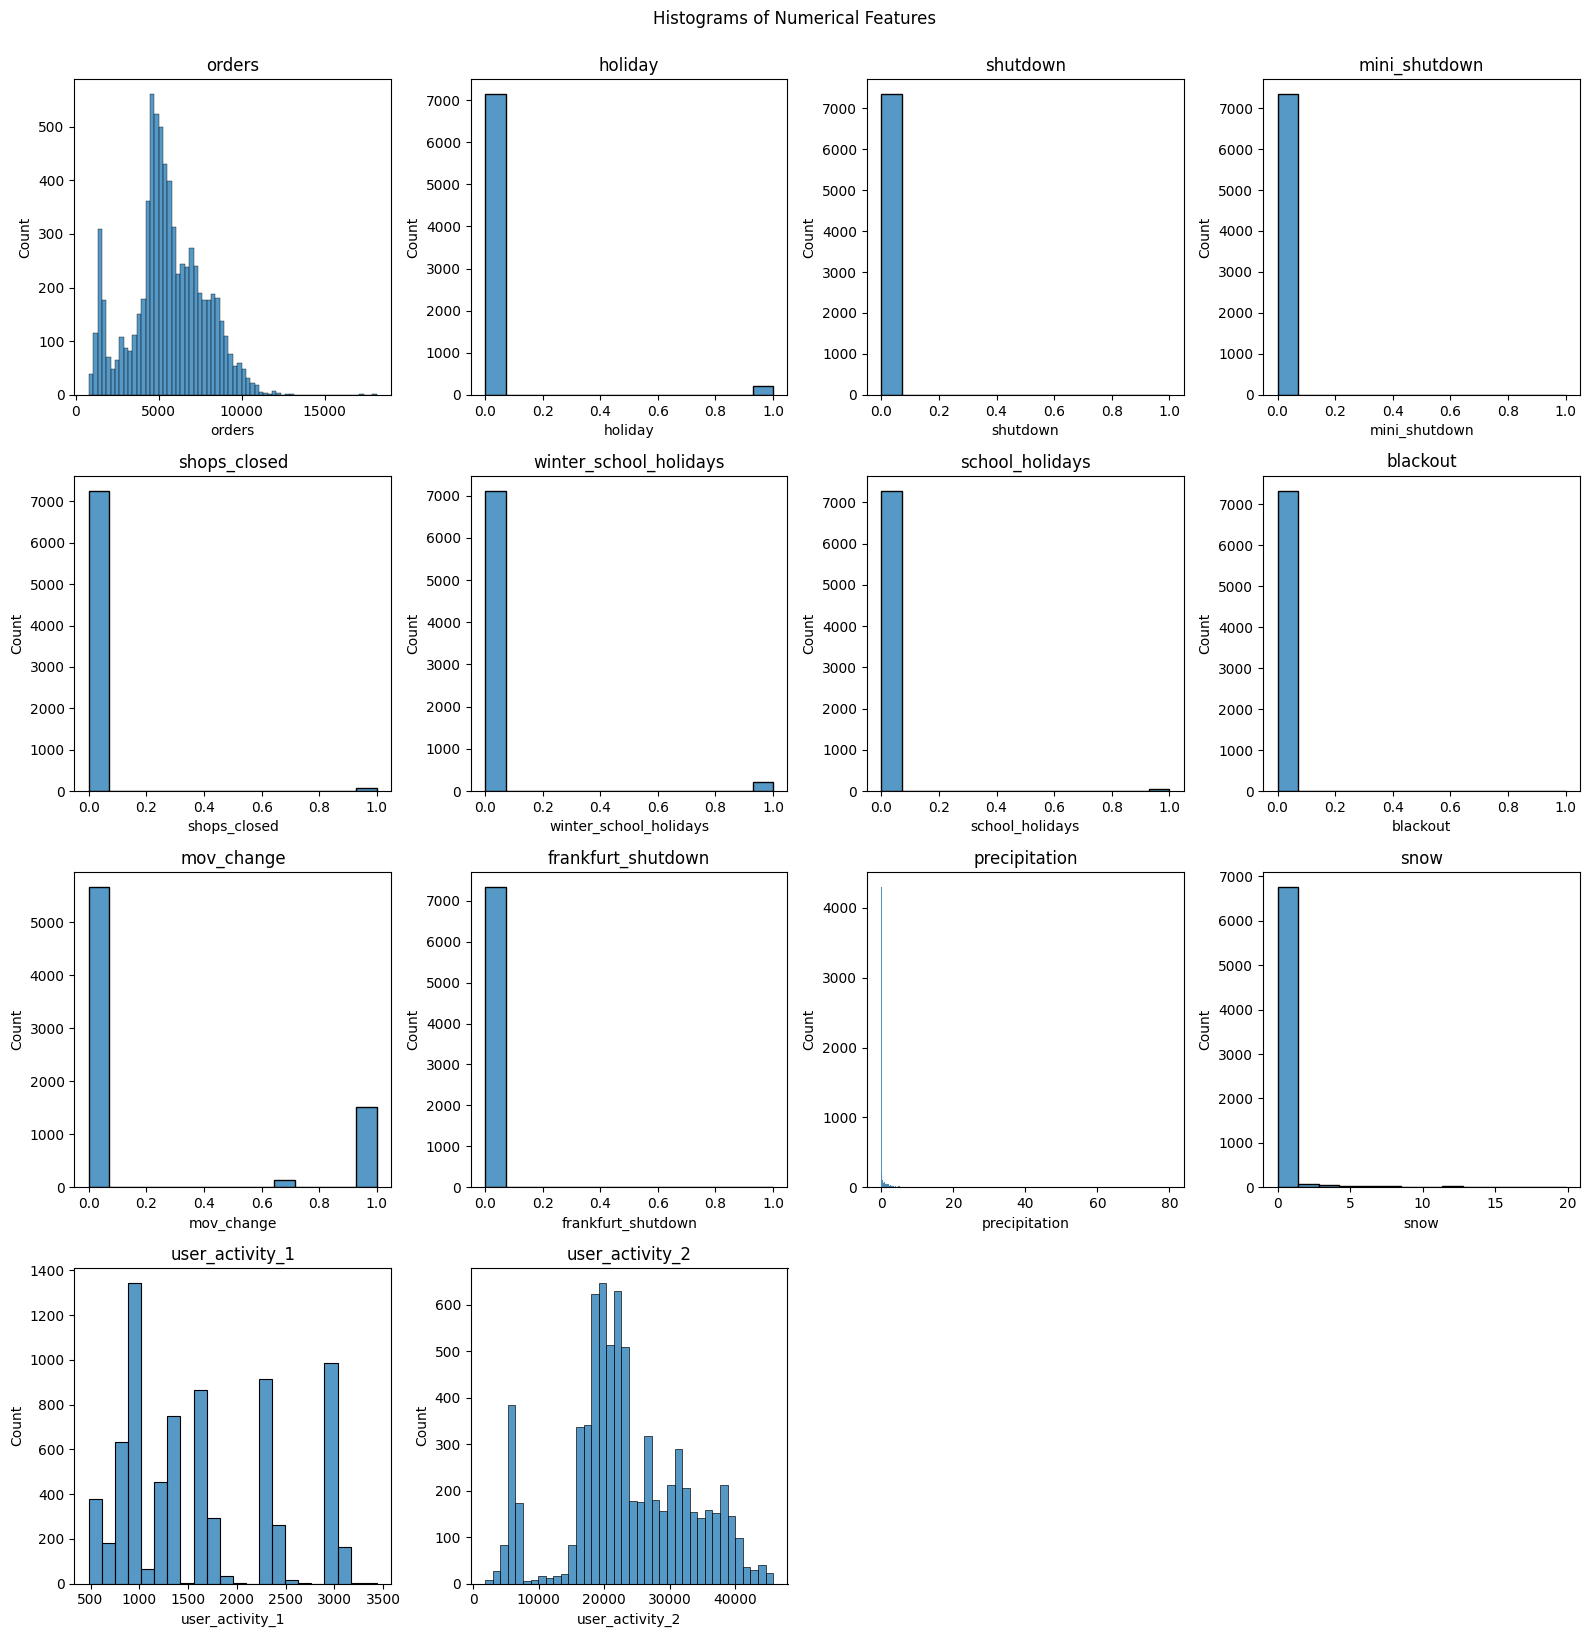

In [4]:
# Numerical features
numerical_features = train_df.select_dtypes(include=['float64', 'int64']).columns

# Determine number of rows and columns for the grid
num_features = len(numerical_features)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols  

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    sns.histplot(train_df[feature], ax=axes[i], kde=False)
    axes[i].set_title(feature)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', y=1.02)  
plt.show()

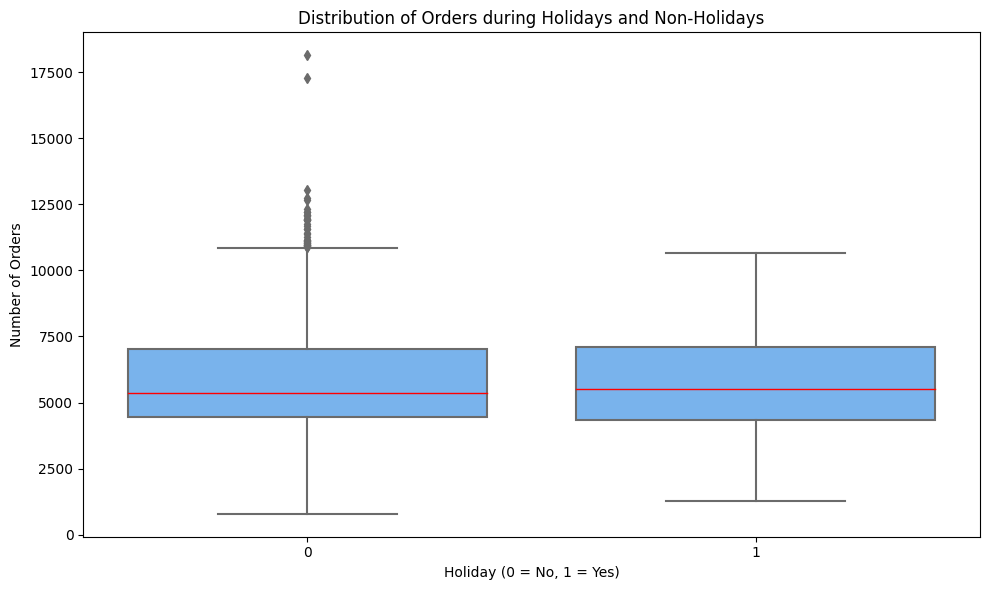

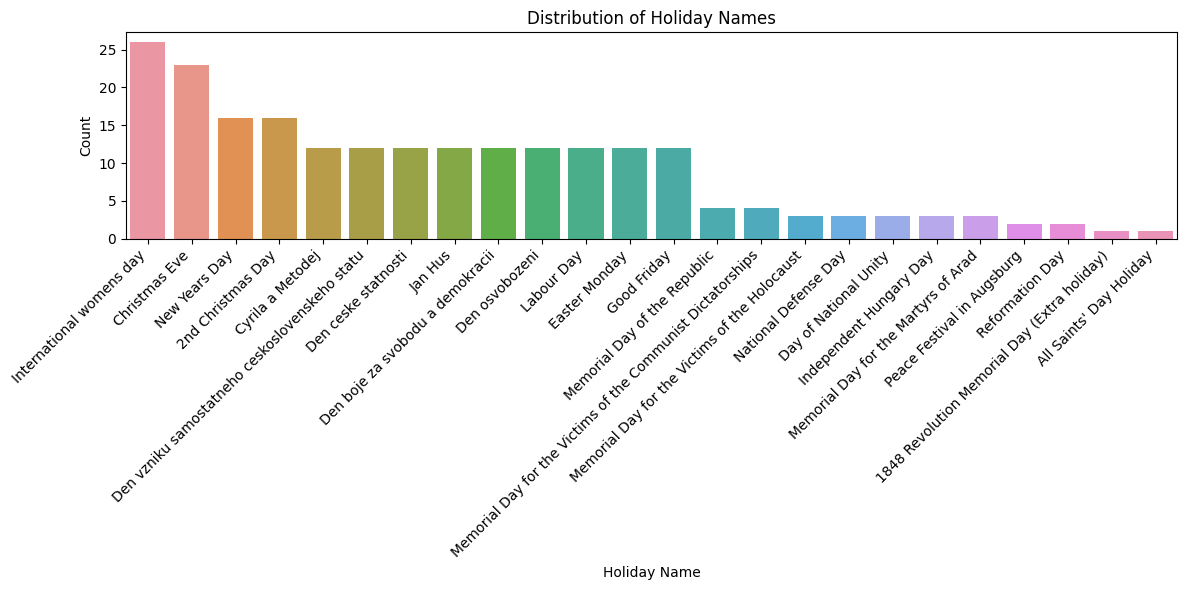

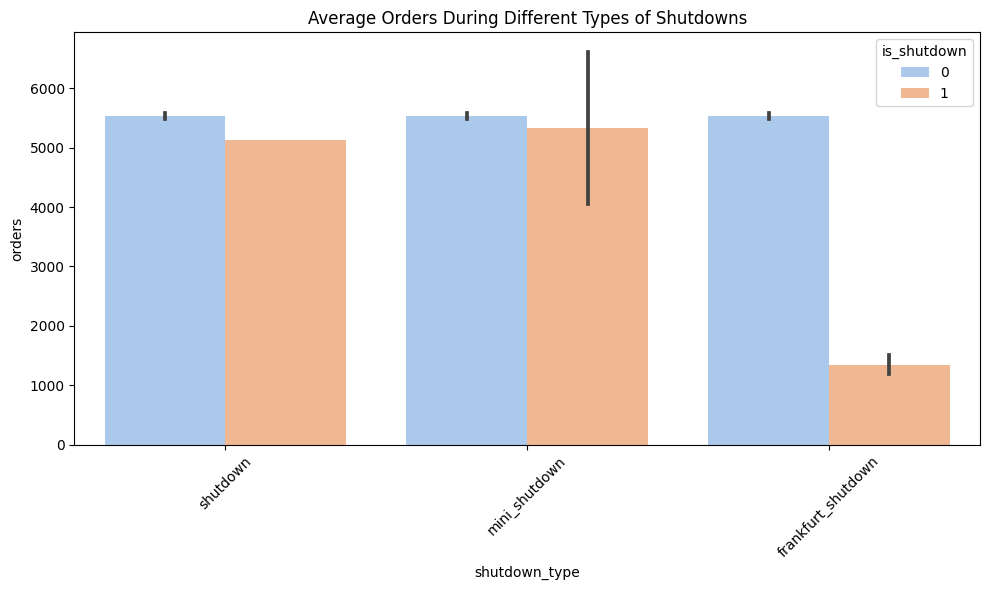

In [5]:
# Calculate the number of missing holiday_name column
missing_values = train_df['holiday_name' ].isnull().sum()
non_missing_values = train_df['holiday_name'].notnull().sum()
missing_data = pd.DataFrame({
    'Count': [missing_values, non_missing_values],
    'Type': ['Missing', 'Non-Missing']})

# Count plot
plt.figure(figsize=(4, 4))
plt.bar(missing_data['Type'], missing_data['Count'], color=['salmon', 'green'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Missing vs Non-Missing Values in Holiday Name Column')
plt.show()

# Orders by Warehouse
plt.figure(figsize=(10, 6))
sns.boxplot(y='warehouse', x='orders', data=train_df, orient='h',
           medianprops={"color": "y", "linewidth": 1})
plt.title('Orders by Warehouse')
plt.xlabel('Number of Orders')
plt.ylabel('Warehouse')
plt.show()

# Orders during Holidays and Non Holidays
plt.figure(figsize=(10, 6))  
sns.boxplot(data=train_df, x='holiday', y='orders', color='#66b3ff',
            medianprops={"color": "r", "linewidth": 1})  
plt.xlabel('Holiday (0 = No, 1 = Yes)')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders during Holidays and Non-Holidays')
plt.tight_layout()
plt.show()


# Create the countplot
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='holiday_name', order=train_df['holiday_name'].value_counts().index)
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Holiday Name')
plt.ylabel('Count')
plt.title('Distribution of Holiday Names')
plt.tight_layout()
plt.show()

# Orders during shutdown
shutdown_cols = ['shutdown','mini_shutdown','frankfurt_shutdown']
shutdown_data = train_df.melt(id_vars=['orders'], value_vars=shutdown_cols, 
                              var_name='shutdown_type', value_name='is_shutdown')
plt.figure(figsize=(10, 6))
sns.barplot(x='shutdown_type', y='orders', hue='is_shutdown', data=shutdown_data,
           palette='pastel')
plt.title('Average Orders During Different Types of Shutdowns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

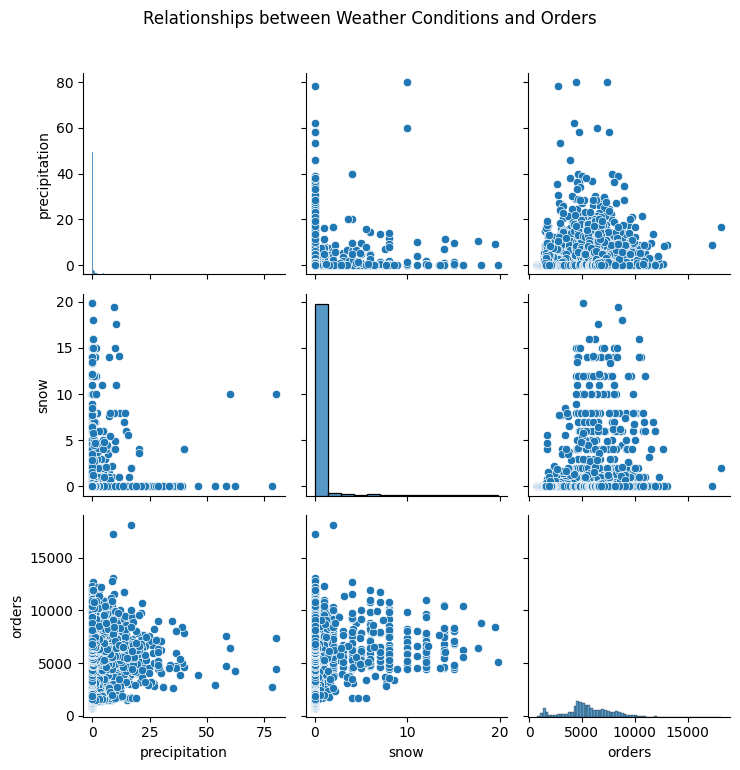

In [6]:
# Orders vs weather
sns.pairplot(train_df[['precipitation','snow','orders']])
plt.suptitle('Relationships between Weather Conditions and Orders', y=1.02)
plt.tight_layout()
plt.show()

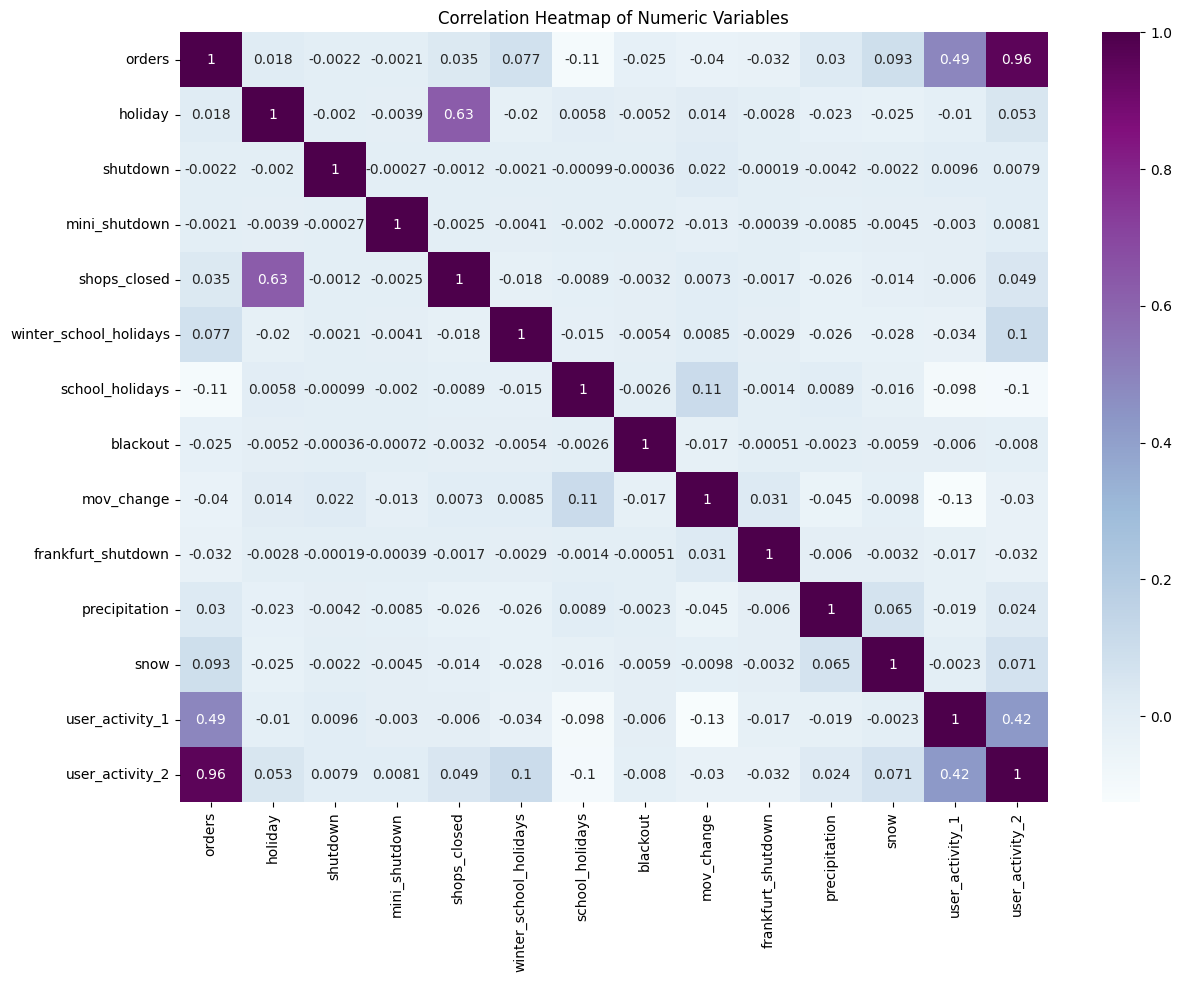

In [7]:
# Corr Matrix
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(14, 10))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap="BuPu")
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

# preprocess

In [8]:
def preprocess_data(train_df, test_df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    train_df['warehouse'] = label_encoder.fit_transform(train_df['warehouse'])
    test_df['warehouse'] = label_encoder.transform(test_df['warehouse'])

    # Drop holiday_name column due to many missing values and low variance
    train_df.drop('holiday_name', axis=1, inplace=True)
    test_df.drop('holiday_name', axis=1, inplace=True)

    # Fill missing values in train_df
    for column in ['precipitation', 'snow']:
        train_df[column].fillna(train_df[column].mean(), inplace=True)

    # Ensure test_df has all columns present in train_df
    for column in train_df.columns:
        if column not in test_df.columns:
            test_df[column] = np.nan

    # Fill missing values in test_df using train_df means
    for column in ['precipitation', 'snow']:
        test_df[column].fillna(train_df[column].mean(), inplace=True)

    return train_df, test_df

# Call function
train_df, test_df = preprocess_data(train_df, test_df)

# feature engineering

In [9]:
# Convert date columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Ensure datasets are sorted by date for proper temporal ordering
train_df = train_df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)
test_df = test_df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)

# Feature Engineering
def create_features(df, is_train=True):
    # Date-based features
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['day'] = df['date'].dt.day
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    # Holiday feature (example: New Year's Day)
    holidays = pd.to_datetime(['2025-01-01'])  # Add more holidays as needed
    df['holiday'] = df['date'].isin(holidays).astype(int)

    # Interaction feature: precipitation * holiday
    df['precipitation_holiday_interaction'] = df['precipitation'] * df['holiday']

    # Lag features for sales (orders)
    if is_train:
        for lag in [7, 14, 30]:
            df[f'orders_lag_{lag}'] = df.groupby('warehouse')['orders'].shift(lag)

        # Rolling statistics for sales
        for window in [7, 14]:
            df[f'orders_roll_mean_{window}'] = (
                df.groupby('warehouse')['orders']
                .shift(1)
                .rolling(window=window)
                .mean()
            )
            df[f'orders_roll_std_{window}'] = (
                df.groupby('warehouse')['orders']
                .shift(1)
                .rolling(window=window)
                .std()
            )
    return df

# Apply feature engineering to train and test datasets
train_df = create_features(train_df, is_train=True)

# For test_df, no access to orders is allowed, so avoid lag/rolling features
test_df = create_features(test_df, is_train=False)

# Fill NaN values for lagged/rolling features in train_df
feature_cols = [col for col in train_df.columns if col not in ['id', 'warehouse', 'date', 'orders']]
train_df[feature_cols] = train_df[feature_cols].fillna(0)

# Ensure test_df has consistent features
test_df = test_df.assign(**{col: 0 for col in feature_cols if col not in test_df.columns})

# Additional check for data leakage
# Validate no overlap in date ranges between train and test sets
assert train_df['date'].max() < test_df['date'].min(), "Data leakage detected: Train and test dates overlap."

# Output result
print("Feature engineering completed without data leakage.")


Feature engineering completed without data leakage.


In [10]:
# Convert date columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Ensure datasets are sorted by date for proper temporal ordering
train_df = train_df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)
test_df = test_df.sort_values(by=['warehouse', 'date']).reset_index(drop=True)

# Feature Engineering
def create_features(df, is_train=True):
    # Date-based features
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['day'] = df['date'].dt.day
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    # Holiday feature (example: New Year's Day)
    holidays = pd.to_datetime(['2025-01-01'])  # Add more holidays as needed
    df['holiday'] = df['date'].isin(holidays).astype(int)

    # Lag features for sales (orders)
    if is_train:
        for lag in [7, 14, 30]:
            df[f'orders_lag_{lag}'] = df.groupby('warehouse')['orders'].shift(lag)

        # Rolling statistics for sales
        for window in [7, 14]:
            df[f'orders_roll_mean_{window}'] = (
                df.groupby('warehouse')['orders']
                .shift(1)
                .rolling(window=window)
                .mean()
            )
            df[f'orders_roll_std_{window}'] = (
                df.groupby('warehouse')['orders']
                .shift(1)
                .rolling(window=window)
                .std()
            )
    return df

# Apply feature engineering to train and test datasets
train_df = create_features(train_df, is_train=True)

# For test_df, no access to orders is allowed, so avoid lag/rolling features
test_df = create_features(test_df, is_train=False)

# Fill NaN values for lagged/rolling features in train_df
feature_cols = [col for col in train_df.columns if col not in ['id', 'warehouse', 'date', 'orders']]
train_df[feature_cols] = train_df[feature_cols].fillna(0)

# Ensure test_df has consistent features
test_df = test_df.assign(**{col: 0 for col in feature_cols if col not in test_df.columns})

# Additional check for data leakage
# Validate no overlap in date ranges between train and test sets
assert train_df['date'].max() < test_df['date'].min(), "Data leakage detected: Train and test dates overlap."

# Output result
print("Feature engineering completed without data leakage.")


Feature engineering completed without data leakage.


In [11]:
# Drop the date columns
train_df.drop('date', axis=1, inplace=True)
test_df.drop('date', axis=1, inplace=True)

# Copy id for later submission
test_ids = test_df['id'].copy()

# Drop unecessary columns
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

# modeling

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Feature selection
features = [
    'warehouse', 'holiday', 'shutdown', 'mini_shutdown', 'shops_closed', 
    'winter_school_holidays', 'school_holidays', 'blackout', 'mov_change',
    'frankfurt_shutdown', 'precipitation', 'snow', 'user_activity_1', 
    'user_activity_2', 'day_of_week', 'week_of_year', 'month', 'year', 
    'orders_lag_7', 'orders_lag_14', 'orders_lag_30', 'orders_roll_mean_7', 
    'orders_roll_std_7', 'orders_roll_mean_14', 'orders_roll_std_14'
]

X = train_df[features]
y = train_df['orders']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 7, 9],
    'n_estimators': [100, 300, 500, 700, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10],
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform search
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Train final model with best parameters
final_model = xgb.XGBRegressor(
    **best_params, objective='reg:squarederror', random_state=42
)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae', early_stopping_rounds=50, verbose=0)

# Validate the model
y_pred_train = final_model.predict(X_train)
y_pred_val = final_model.predict(X_val)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-5, y_true)  # Replace zeros with a small value
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
val_mape = mean_absolute_percentage_error(y_val, y_pred_val)

print(f"Training MAPE: {train_mape:.2f}%")
print(f"Validation MAPE: {val_mape:.2f}%")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Training MAPE: 1.92%
Validation MAPE: 3.90%


# feature importance

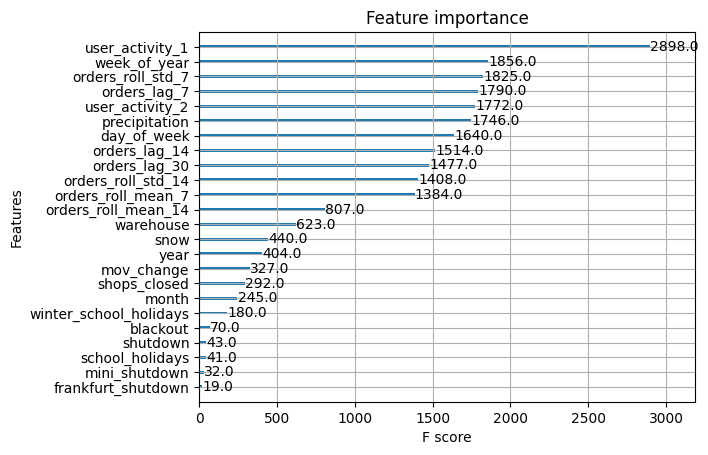

In [13]:
# Feature importance
xgb.plot_importance(final_model, importance_type='weight')
plt.show()

# predict on test data and submission

In [14]:
# Predict on test data
test_predictions = final_model.predict(test_df[features])

# Create submission file
submission = pd.DataFrame({'id': test_ids, 'orders': test_predictions})

# Save submission
submission.to_csv('submission.csv', index=False)

print("Predictions saved!")
submission.head()

Predictions saved!


,id,orders
0,Brno_1_2024-03-16,7448.027832
1,Brno_1_2024-03-17,7077.446289
2,Brno_1_2024-03-18,7250.367188
3,Brno_1_2024-03-19,7263.445801
4,Brno_1_2024-03-20,7278.342285
